[comment]: <> ( __@this notebook__ will guide you through a very simple case of generative adversarial networks.) 

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>


[//]: <> ( Like.. veeery simple. Generative adversarial networks that learn to convert 1d uniform noise distribution to a uniform 1d normal data distribution.)

# В этом ноутбуке мы попробуем генерировать одномерное нормальное распределение из равномерного распределения

In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
# Тут генератор пытается преобразовать шум в реальные данные
gen = nn.Sequential(nn.Linear(1, 16), nn.ELU(), nn.Linear(16, 1))
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)


# А дискриминатор пытается отличить сгенерированные данные от настоящих
# Он возвращает массив из двух чисел
# Где первое число равное вероятности пренадлежности объекта к сгенерированным данным 
# А второе к реальным данным
disc = nn.Sequential(nn.Linear(1, 64), nn.ELU(), nn.Linear(64, 2))
disc_opt = torch.optim.SGD(disc.parameters(), lr=1e-2)

In [10]:
IS_FAKE, IS_REAL = 0, 1

def sample_real_data(n):
    return Variable(torch.randn(n, 1) * 1.5 + 5)

def sample_noise(n):
    return Variable(torch.rand(n, 1))

def train_disc(batch_size):
    """
    Один шаг дискриминатора
    """
    
    # Посчитаем log p(real | x) 
    real_data = sample_real_data(batch_size)
    logp_real_is_real = F.log_softmax(disc(real_data), dim=1)[:, IS_REAL]
    
    # Посчитаем logp(fake | G(z))
    noise = sample_noise(batch_size)
    gen_data = gen(noise)
    logp_gen_is_fake = F.log_softmax(disc(gen_data), dim=1)[:, IS_FAKE]
    
    disc_loss = - (torch.mean(logp_gen_is_fake) + torch.mean(logp_real_is_real))
    
    # Градиентный шаг
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss.data.numpy()

In [11]:
def train_gen(batch_size):
    """ 
    Один шаг генератора
    """
        
    # Посчитаем log p(fake | G(z)).
    noise = sample_noise(batch_size)
    gen_data = gen(noise)
    
    logp_gen_is_real = F.log_softmax(disc(gen_data), dim=1)[:, IS_REAL]
    
    gen_loss = -torch.mean(logp_gen_is_real)
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss.data.numpy()

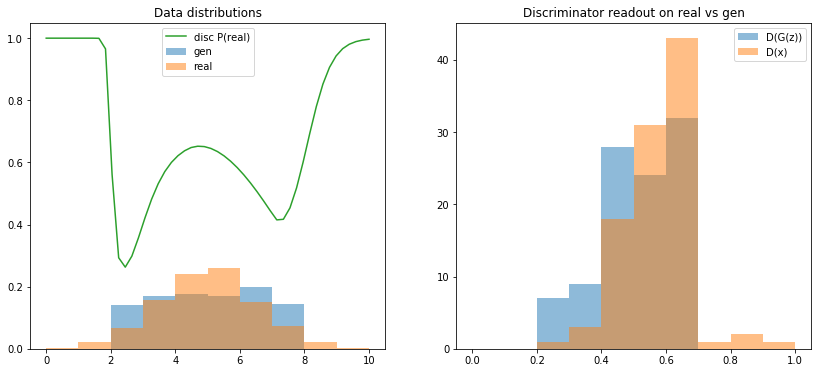

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

for i in range(100000):

    for _ in range(5):
        train_disc(128)
    
    train_gen(128)
    
    if i % 250 == 0:
        clear_output(True)
        plt.figure(figsize=[14, 6])
        plt.subplot(1, 2, 1)
        plt.title("Data distributions")
        plt.hist(gen(sample_noise(1000)).data.numpy()[:, 0], range=[0, 10], alpha=0.5, normed=True, label='gen')
        plt.hist(sample_real_data(1000).data.numpy()[:,0], range=[0, 10], alpha=0.5, normed=True, label='real')
        
        x = np.linspace(0,10, dtype='float32')
        disc_preal = F.softmax(disc(Variable(torch.from_numpy(x[:, None]))))[:, 1]
        plt.plot(x, disc_preal.data.numpy(), label='disc P(real)')
        plt.legend()
        

        plt.subplot(1, 2, 2)
        plt.title("Discriminator readout on real vs gen")
        plt.hist(F.softmax(disc(gen(sample_noise(100))))[:, 1].data.numpy(),
                 range=[0, 1], alpha=0.5, label='D(G(z))')
        plt.hist(F.softmax(disc(sample_real_data(100)))[:, 1].data.numpy(),
                 range=[0, 1], alpha=0.5, label='D(x)')
        plt.legend()
        plt.show()

__Что ожидается увидеть на графиках:__
* __Левый:__ Два распределения начнутся по-разному, но распределение генератора должно соответствовать реальным данным почти везде. Кривая представляет мнение дискриминатора по всем возможным значениям x. Он должен медленно приближаться к 0,5 над областями, где реальные данные плотны.
* __Правый:__ На этой диаграмме показано, как часто дискриминатор назначает заданную вероятность выборкам из реальных и сгенерированных выборок данных (показано разными цветами). Первые несколько итераций будут отличаться, но в конечном итоге они оба будут иметь почти всю массу вероятности около 0,5, поскольку генератор становится лучше в своей работе.
 * Если вместо этого она сходится вокруг 0 (gen) и 1(real), Ваш дискриминатор выиграл. В качестве окончательной ошибки попробуйте уменьшить скорость обучения дискриминатора. Это также может произойти, если заменить среднее значение по батчу на сумму или подобное.
 * Если он сходится к 0.5 и остается там в течение нескольких итераций, но генератор еще не научился генерировать правдоподобные данные, генератор проигрывает игру.